In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
from functions import compute_r, rho_model, log_rho_model, compute_r_fast, rho_model_fast

plt.style.use('ggplot')
coordinates_df = pd.read_csv('../data/coordinates.csv')

In [3]:
n_events = 100

Ne, s = 1e6, 1.2
theta, phi = 30, 210
Z0 = - 18
X0_array = np.random.uniform(-40, 40, size=n_events)
Y0_array = np.random.uniform(-70, 70, size=n_events)

initial_params = [0,  0,  1e5, 1.5]
bounds = [
    (-50, 50),  # X0
    (-80, 80),  # Y0
    (1, 1e8),  # Ne
    (0.2, 2)  # s
]

In [4]:
x_coords = np.arange(-50, 51, 20)
y_coords = np.arange(-80, 81, 20)
z_coord = -18


xx, yy = np.meshgrid(x_coords, y_coords)

my_coordindates_df = pd.DataFrame({
    'X': xx.flatten(),
    'Y': yy.flatten(),
    'Z': z_coord
})

my_coordindates_df = my_coordindates_df.sort_values(
    ['Y', 'X']).reset_index(drop=True)

print(f"Всего точек: {len(my_coordindates_df)}")

Всего точек: 54


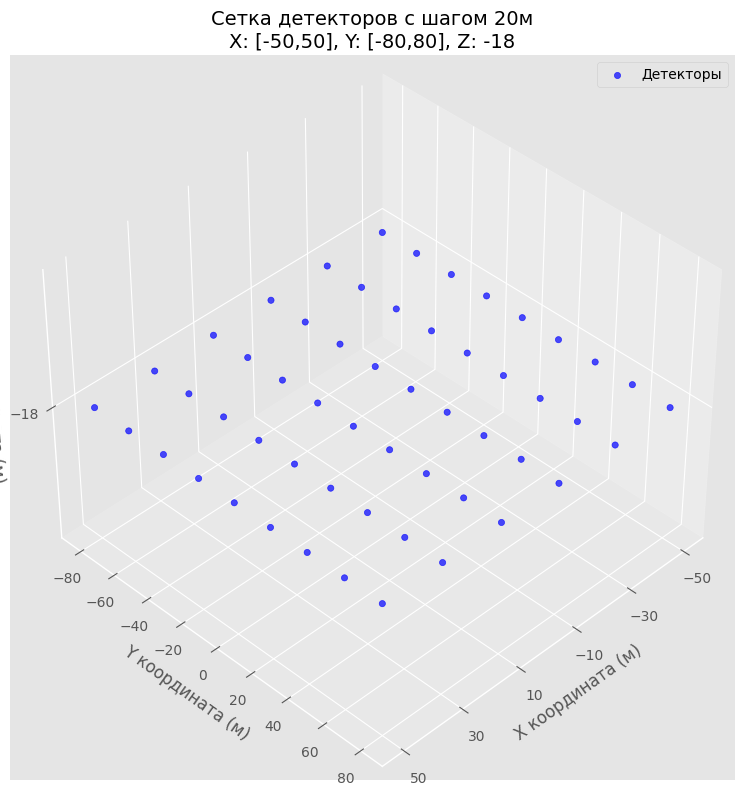

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Визуализируем точки сетки
ax.scatter(my_coordindates_df['X'], my_coordindates_df['Y'], my_coordindates_df['Z'],
           c='blue', s=20, alpha=0.7, label='Детекторы')

# Настройка осей
ax.set_xlabel('X координата (м)', fontsize=12)
ax.set_ylabel('Y координата (м)', fontsize=12)
ax.set_zlabel('Z координата (м)', fontsize=12)
ax.set_title(
    'Сетка детекторов с шагом 20м\nX: [-50,50], Y: [-80,80], Z: -18', fontsize=14)

# Линии сетки
ax.set_xticks(np.arange(-50, 51, 20))
ax.set_yticks(np.arange(-80, 81, 20))
ax.set_zticks([-18])

# Дополнительные настройки
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=10)

# Угол обзора
ax.view_init(elev=40, azim=45)  # Изменяйте эти значения для разного ракурса

plt.tight_layout()
plt.show()

In [6]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    X_det, Y_det, Z_det = coordinates_df[['X', 'Y', 'Z']].values.T
    r = compute_r(X0, Y0, Z0, theta, phi, X_det, Y_det, Z_det)
    rho_calc = rho_model(r, Ne, s)
    # return np.mean((rho_calc - rho) ** 2)
    return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)

In [7]:
def pad_array(arr, max_len):
    return np.pad(arr, (0, max_len - len(arr)), mode='constant', constant_values=np.nan)

In [13]:
def find_my_params(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s):
    r_list, rho_list = [], []
    X0_list, Y0_list = [], []
    Ne_list, s_list = [], []
    mrpe_list = []
    R_list, RHO_list = [], []
    
    threshold = 0.75 * 8.2 * 0.4 * 0.4 * 4

    for i in tqdm(range(n_events), desc="Processing events"):
        X0, Y0 = X0_array[i], Y0_array[i]
        X_det, Y_det, Z_det = coordinates[['X', 'Y', 'Z']].values.T

        r = compute_r(X0, Y0, Z0, theta, phi, X_det, Y_det, Z_det)
        rho = rho_model(r, Ne, s)
        mask = rho >= threshold
        
        if not np.any(mask):
            continue
            
        # Применяем маску к данным
        filtered_coordinates = coordinates[mask]
        filtered_rho = rho[mask]
        filtered_r = r[mask]
        X_det, Y_det, Z_det = filtered_coordinates[['X', 'Y', 'Z']].values.T
        
        
        # result = differential_evolution(
        #     loss_function,
        #     bounds,
        #     args=(filtered_coordinates, filtered_rho, theta, phi, Z0)
        # )
        
        result = differential_evolution(
            loss_function,
            bounds=bounds,
            args=(filtered_coordinates, filtered_rho, theta, phi, Z0),
            strategy='rand1bin',
            maxiter=50,             # ограничение итераций
            popsize=10,             # особи в популяции
            tol=0.01,               # < остановка 
            atol=0.01,              # допуск
            mutation=(0.5, 1.0),    # разброс новых решений
            recombination=0.7,
            seed=42,
            disp=True,
            workers=-1,
            updating='deferred',
            polish=False
        )
        
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x
        
        R = compute_r(X0_opt, Y0_opt, Z0, theta, phi, X_det, Y_det, Z_det)
        RHO = rho_model(R, Ne_opt, s_opt)
        
        mrpe = np.mean(np.abs((RHO - filtered_rho) / filtered_rho))
        
        mrpe_list.append(mrpe)
        r_list.append(filtered_r)
        R_list.append(R)
        rho_list.append(filtered_rho)
        RHO_list.append(RHO)
        X0_list.append(X0_opt)
        Y0_list.append(Y0_opt)
        Ne_list.append(Ne_opt)
        s_list.append(s_opt)
        

    return (
        r_list,
        R_list,
        rho_list,
        RHO_list,
        X0_list,
        Y0_list,
        Ne_list,
        s_list,
        mrpe_list
    )

In [ ]:
results = find_my_params(
    my_coordindates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s)
r_array, R_array, rho_array, RHO_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array, mrpe_array = results

Processing events:   0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
r_opt_array = []
rho_opt_array = []

for i in range(len(X0_opt_array)):
    # Получаем оптимизированные параметры для текущего события
    X0 = X0_opt_array[i]
    Y0 = Y0_opt_array[i]
    Ne = Ne_opt_array[i]
    s = s_opt_array[i]
    X_det, Y_det, Z_det = my_coordindates_df[['X', 'Y', 'Z']].values.T
    
    
    # Вычисляем r и rho с оптимизированными параметрами
    r = compute_r(X0, Y0, Z0, theta, phi,  X_det, Y_det, Z_det)
    rho = rho_model(r, Ne, s)
    
    # Сохраняем результаты
    r_opt_array.append(r)
    rho_opt_array.append(rho)

# Преобразуем списки в numpy массивы
r_opt_array = np.array(r_opt_array)
rho_opt_array = np.array(rho_opt_array)

In [52]:
delta_X0 = X0_opt_array - X0_array
delta_Y0 = Y0_opt_array - Y0_array
delta_Ne = (Ne_opt_array - Ne) / Ne
delta_s = (s_opt_array - s) / s

In [53]:
def find_limit(nums):
    return abs(max(nums, key=lambda x: abs(x)))

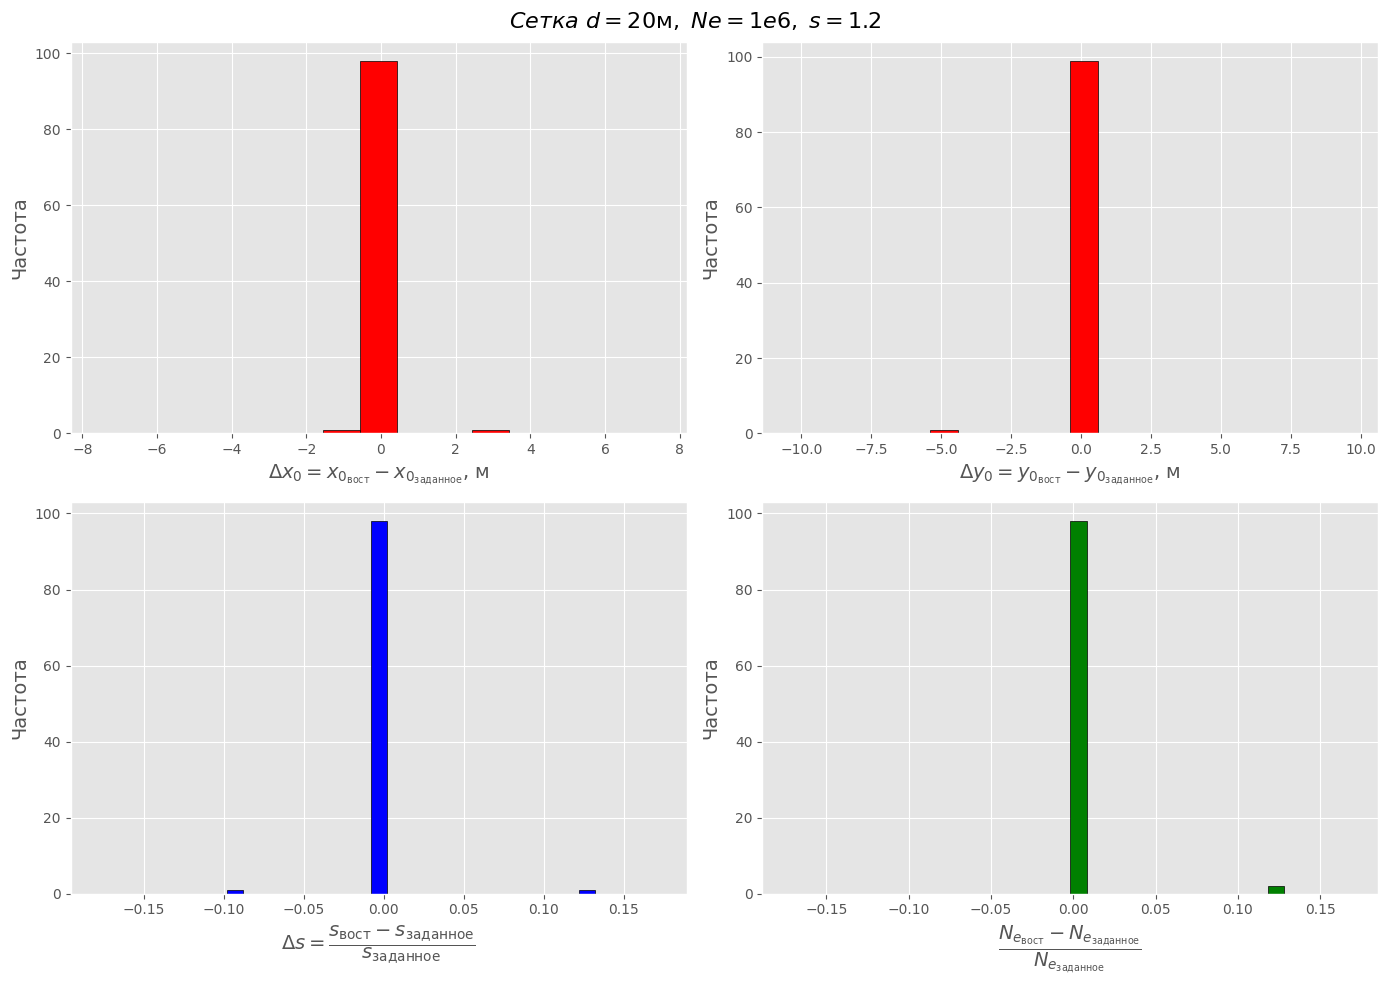

In [54]:
interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 0.01
interval_delta_Ne = 0.01

limit_X, limit_Y = find_limit(delta_X0), find_limit(delta_Y0)
limit_Ne, limit_s = find_limit(delta_Ne), find_limit(delta_s)

bin_edges_delta_X = np.arange(-limit_X - 5, limit_X + 5, interval_delta_X)
bin_edges_delta_Y = np.arange(-limit_Y - 5, limit_Y + 5, interval_delta_Y)

bin_edges_delta_s = np.arange(-limit_s - 0.05, limit_s + 0.05, interval_delta_s)
bin_edges_delta_Ne = np.arange(-limit_Ne - 0.05, limit_Ne + 0.05, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(r'$Сетка~d=20\text{м},~Ne=1e6,~ s=1.2$', fontsize=16)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0_{\text{вост}}} - x_{0_{\text{заданное}}}$, м', fontsize=14)
axes[0, 0].set_ylabel("Частота", fontsize=14)

# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0_{\text{вост}}} - y_{0_{\text{заданное}}}$, м', fontsize=14)
axes[0, 1].set_ylabel("Частота", fontsize=14)

# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\Delta s = \dfrac{s_{\text{вост}} - s_{\text{заданное}}}{s_{\text{заданное}}}$',  fontsize=14)
axes[1, 0].set_ylabel("Частота",  fontsize=14)

# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{заданное}}}}{N_{e_{\text{заданное}}}}$',  fontsize=14)
axes[1, 1].set_ylabel("Частота",  fontsize=14)

# fig.legend()

# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
# plt.savefig(fr'plots_testing/my_grid/d=20/delta_r,s_1.2,Ne_1e7,noise00.png',
#             dpi=500, bbox_inches="tight")
plt.show()

d:\github\repositories\sdf\corsika\functions.py:29: RuntimeWarning: divide by zero encountered in power
  term2 = (r / r_m) ** (s - 2)


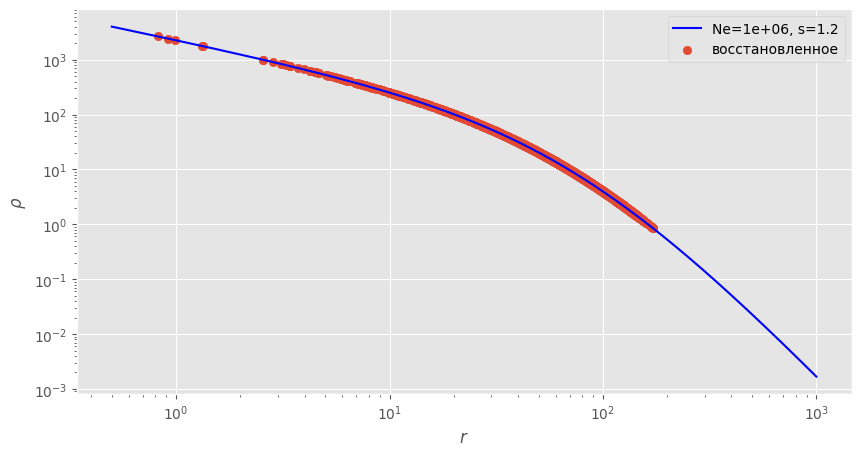

In [34]:
r = np.arange(0, 1e3, 0.5)
rho = rho_model(r, Ne, s)

plt.figure(figsize=(10, 5))
plt.plot(r, rho, label=f"Ne={Ne:.0e}, s={s}", color='b')

plt.scatter(r_opt_array, rho_opt_array, label="восстановленное")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()